# Setup

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder
import torchvision

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

In [ ]:
base_url = "https://upload.wikimedia.org/wikipedia/commons/b/b4/Nine-banded_Armadillo.jpg"
style_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/2/2b/Spider_Cobweb_%28blue%29.jpg/519px-Spider_Cobweb_%28blue%29.jpg"
style2_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/7/7b/Japanese_Maple_Bark_by_David_Shankbone.jpg/1024px-Japanese_Maple_Bark_by_David_Shankbone.jpg"

# Loading images

In [ ]:
fc.urlread?

Signature:
fc.urlread(
    url,
    data=None,
    headers=None,
    decode=True,
    return_json=False,
    return_headers=False,
    timeout=None,
    **kwargs,
)
Docstring: Retrieve `url`, using `data` dict or `kwargs` to `POST` if present
File:      ~/miniforge3/envs/fastai/lib/python3.11/site-packages/fastcore/net.py
Type:      function

In [ ]:
torchvision.io.decode_image?

Signature:
torchvision.io.decode_image(
    input: torch.Tensor,
    mode: torchvision.io.image.ImageReadMode = <ImageReadMode.UNCHANGED: 0>,
) -> torch.Tensor
Docstring:
Detects whether an image is a JPEG or PNG and performs the appropriate
operation to decode the image into a 3 dimensional RGB or grayscale Tensor.

Optionally converts the image to the desired format.
The values of the output tensor are uint8 in [0, 255].

Args:
    input (Tensor): a one dimensional uint8 tensor containing the raw bytes of the
        PNG or JPEG image.
    mode (ImageReadMode): the read mode used for optionally converting the image.
        Default: ``ImageReadMode.UNCHANGED``.
        See ``ImageReadMode`` class for more information on various
        available modes.

Returns:
    output (Tensor[image_channels, image_height, image_width])
File:      ~/miniforge3/envs/fastai/lib/python3.11/site-packages/torchvision/io/image.py
Type:      function

In [ ]:
print(dir(torchvision.io.ImageReadMode))

['GRAY', 'GRAY_ALPHA', 'RGB', 'RGB_ALPHA', 'UNCHANGED', '__class__', '__contains__', '__doc__', '__getitem__', '__init_subclass__', '__iter__', '__len__', '__members__', '__module__', '__name__', '__qualname__']


In [ ]:
image_blob = fc.urlread(base_url, decode=False)

In [ ]:
image = torchvision.io.decode_image(torch.tensor(list(image_blob), dtype=torch.uint8))
image.dtype

torch.uint8

In [ ]:
# show_image(image, figsize=(5,5));

In [ ]:
del image
del image_blob

In [ ]:
def download_image(url):
    image_blob = fc.urlread(url, decode=False)
    image = torchvision.io.decode_image(torch.tensor(list(image_blob), dtype=torch.uint8)) 
    return TF.resize(image, (256, 256), antialias=False).to(torch.float32) / 255.

In [ ]:
base_image = download_image(base_url).to(def_device)

In [ ]:
base_image.shape, base_image.dtype

(torch.Size([3, 256, 256]), torch.float32)

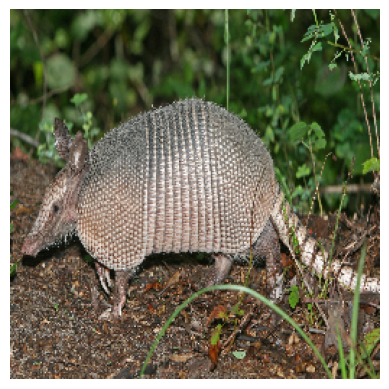

In [ ]:
show_image(base_image);

# Optimizing images

In [ ]:
class LengthDataset:
    def __init__(self, len):
        self.len = len

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return 0, 0

In [ ]:
def get_dummy_dls(len):
    return DataLoaders(
        DataLoader(LengthDataset(len)),
        DataLoader(LengthDataset(1))
    )

In [ ]:
dls = get_dummy_dls(50)

In [ ]:
c = 0
for _ in dls.train:
    c += 1
print(c)

50


In [ ]:
nn.Parameter?

Init signature: nn.Parameter(data=None, requires_grad=True)
Docstring:     
A kind of Tensor that is to be considered a module parameter.

Parameters are :class:`~torch.Tensor` subclasses, that have a
very special property when used with :class:`Module` s - when they're
assigned as Module attributes they are automatically added to the list of
its parameters, and will appear e.g. in :meth:`~Module.parameters` iterator.
Assigning a Tensor doesn't have such effect. This is because one might
want to cache some temporary state, like last hidden state of the RNN, in
the model. If there was no such class as :class:`Parameter`, these
temporaries would get registered too.

Args:
    data (Tensor): parameter tensor.
    requires_grad (bool, optional): if the parameter requires gradient. Note that
        the torch.no_grad() context does NOT affect the default behavior of
        Parameter creation--the Parameter will still have `requires_grad=True` in
        :class:`~no_grad` mode. See :ref:`lo

In [ ]:
class TensorModel(nn.Module):
    def __init__(self, x):
        super().__init__()
        self.x = nn.Parameter(x.clone())

    def forward(self, _=None):
        return self.x

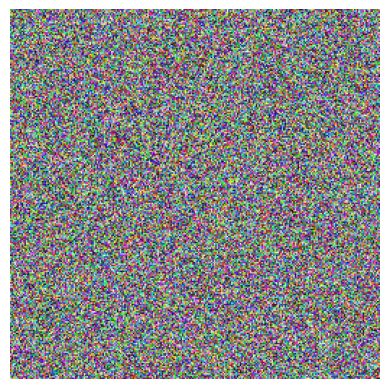

In [ ]:
set_seed(1103)
model = TensorModel(torch.rand_like(base_image))
show_image(model());

In [ ]:
TrainCB.get_loss??

Signature: TrainCB.get_loss(self, learn)
Docstring: <no docstring>
Source:   
    def get_loss(self, learn):
        learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
File:      ~/fastai_course/miniai/learner.py
Type:      function

In [ ]:
class ImageOptCB(TrainCB):
    def predict(self, learn):
        learn.preds = learn.model()

    def get_loss(self, learn):
        learn.loss = learn.loss_func(learn.preds)

In [ ]:
def loss_fn_mse(im):
    return F.mse_loss(im, base_image)

In [ ]:
set_seed(1103)
model = TensorModel(torch.rand_like(base_image))
cbs = [ImageOptCB(), ProgressCB(True), MetricsCB(), DeviceCB()]
learn = Learner(model, get_dummy_dls(50), loss_fn_mse, lr=0.1, cbs=cbs, opt_func=torch.optim.Adam)

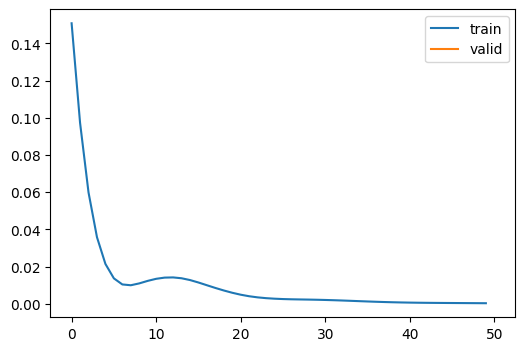

In [ ]:
learn.fit()

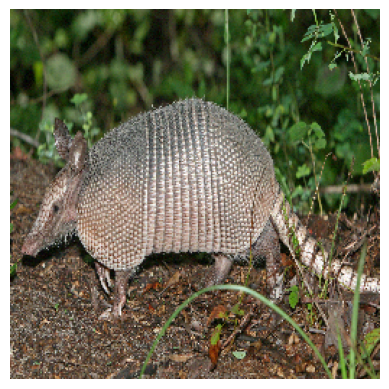

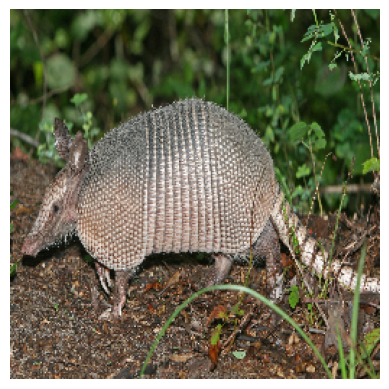

In [ ]:
show_image(model().clip(0, 1))
show_image(base_image);

# Viewing progress

In [ ]:
class ImageLogCB(Callback):
    def __init__(self, log_freq=10):
        self.log_freq = log_freq
        self.log_history = []
        self.step_idx = 0

    def after_batch(self, learn):
        if self.step_idx % self.log_freq == 0:
            self.log_history.append(to_cpu(learn.preds).clip(0, 1))
        self.step_idx += 1

    def after_fit(self, learn):
        show_images(self.log_history)

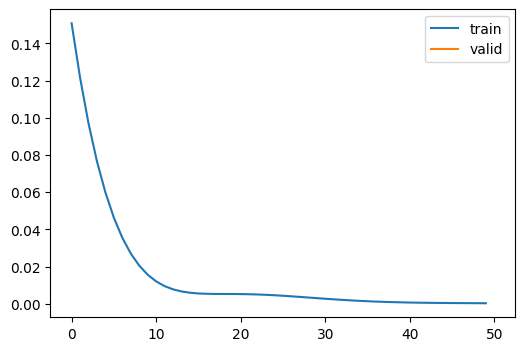

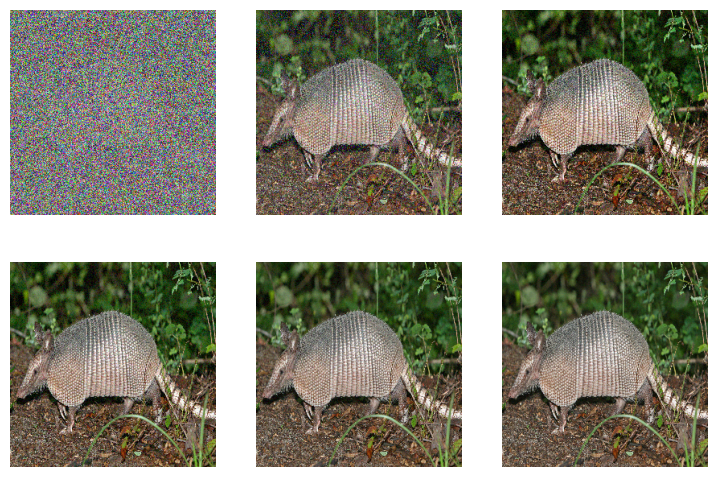

In [ ]:
set_seed(1103)
model = TensorModel(torch.rand_like(base_image))
cbs = [ImageOptCB(), ProgressCB(True), MetricsCB(), DeviceCB(), ImageLogCB()]
learn = Learner(model, get_dummy_dls(50), loss_fn_mse, lr=0.05, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit()

# Getting features from VGG16

## Load VGG network

In [ ]:
import timm

In [ ]:
print(dir(timm))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'create_model', 'data', 'get_pretrained_cfg', 'get_pretrained_cfg_value', 'is_exportable', 'is_model', 'is_model_pretrained', 'is_scriptable', 'layers', 'list_models', 'list_modules', 'list_pretrained', 'model_entrypoint', 'models', 'set_exportable', 'set_scriptable', 'utils', 'version']


In [ ]:
print(list(filter(lambda s: s.find("vgg") != -1, timm.list_models())))

['repvgg_a0', 'repvgg_a1', 'repvgg_a2', 'repvgg_b0', 'repvgg_b1', 'repvgg_b1g4', 'repvgg_b2', 'repvgg_b2g4', 'repvgg_b3', 'repvgg_b3g4', 'repvgg_d2se', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']


In [ ]:
timm.create_model

<function timm.models._factory.create_model(model_name: str, pretrained: bool = False, pretrained_cfg: Union[str, Dict[str, Any], timm.models._pretrained.PretrainedCfg, NoneType] = None, pretrained_cfg_overlay: Optional[Dict[str, Any]] = None, checkpoint_path: str = '', scriptable: Optional[bool] = None, exportable: Optional[bool] = None, no_jit: Optional[bool] = None, **kwargs)>

In [ ]:
vgg16 = timm.create_model("vgg16", True)
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
vgg16 = vgg16.features.to(def_device)

In [ ]:
vgg16(base_image).shape

torch.Size([512, 8, 8])

In [ ]:
imagenet_mean = torch.tensor([0.485, 0.456, 0.406]).to(def_device)
imagenet_std = torch.tensor([0.229, 0.224, 0.225]).to(def_device)

In [ ]:
base_image.shape, imagenet_mean.shape

(torch.Size([3, 256, 256]), torch.Size([3]))

In [ ]:
((base_image - imagenet_mean[:, None, None]) / imagenet_std[:, None, None]).shape

torch.Size([3, 256, 256])

In [ ]:
imagenet_mean = imagenet_mean[:, None, None]
imagenet_std = imagenet_std[:, None, None]

In [ ]:
def normalize(im):
    return (im - imagenet_mean) / imagenet_std

## Get intermediate representations

In [ ]:
def calc_features(imgs, target_layers=(18,25)):
    imgs = normalize(imgs)
    result = []
    last_layer = max(target_layers) + 1
    for i, layer in enumerate(vgg16[:last_layer]):
        imgs = layer(imgs)
        if i in target_layers:
            result.append(imgs)

    return result

In [ ]:
features = calc_features(base_image)

In [ ]:
for feat in features:
    print(feat.shape)
del features

torch.Size([512, 32, 32])
torch.Size([512, 16, 16])


### With hooks

In [ ]:
def save_intermediate(hook, mod, inp, outp):
    hook.intermediate = to_cpu(outp)

In [ ]:
def get_target_layers(model, target_layers=(18,25)):
    target_layers = sorted(target_layers)
    to_hook = []
    model = model[:target_layers[-1] + 1]
    for idx, layer in enumerate(model):
        if idx in target_layers: to_hook.append(layer)
    return model, to_hook

In [ ]:
model, to_hook = get_target_layers(vgg16)
inter_hooks = Hooks(f=save_intermediate, ms=to_hook)
with inter_hooks:
    model(base_image)
for hook in inter_hooks:
    print(hook.intermediate.shape)

torch.Size([512, 32, 32])
torch.Size([512, 16, 16])


In [ ]:
with inter_hooks:
    vgg16(base_image)
for hook in inter_hooks:
    print(hook.intermediate.shape)

torch.Size([512, 32, 32])
torch.Size([512, 16, 16])


# Optimizing an image with content loss

In [ ]:
class ContentLossToTarget(nn.Module):
    def __init__(self, target_im, target_layers=(18,25)):
        super().__init__()
        with torch.no_grad():
            self.target = calc_features(target_im, target_layers)
        self.target_layers = target_layers

    def __call__(self, x):
        features = calc_features(x, self.target_layers)
        loss = 0
        for i, f in enumerate(features):
            loss += F.mse_loss(f, self.target[i])
        return loss

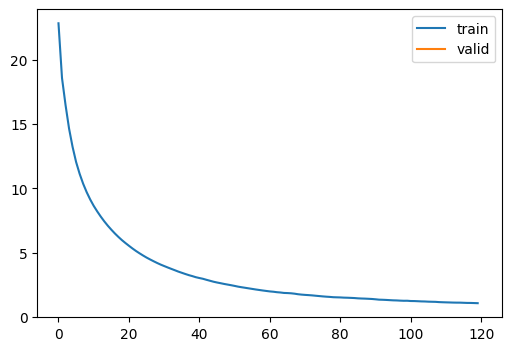

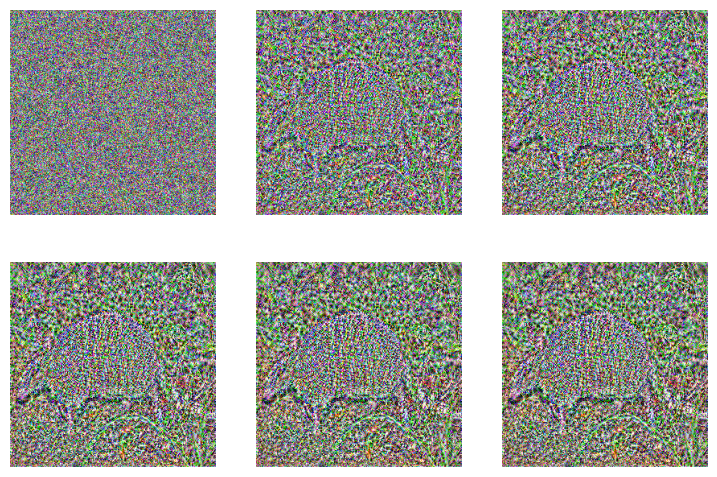

In [ ]:
set_seed(1103)
model = TensorModel(torch.rand_like(base_image))
cbs = [ImageOptCB(), ProgressCB(True), MetricsCB(), DeviceCB(), ImageLogCB(24)]
learn = Learner(model, get_dummy_dls(120), loss_func=ContentLossToTarget(base_image), lr=0.05, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit()

### Choosing the layers determines the kind of features that are important

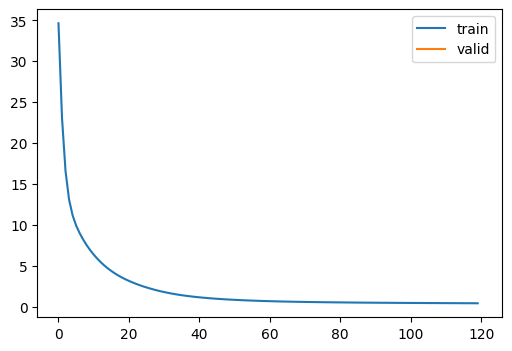

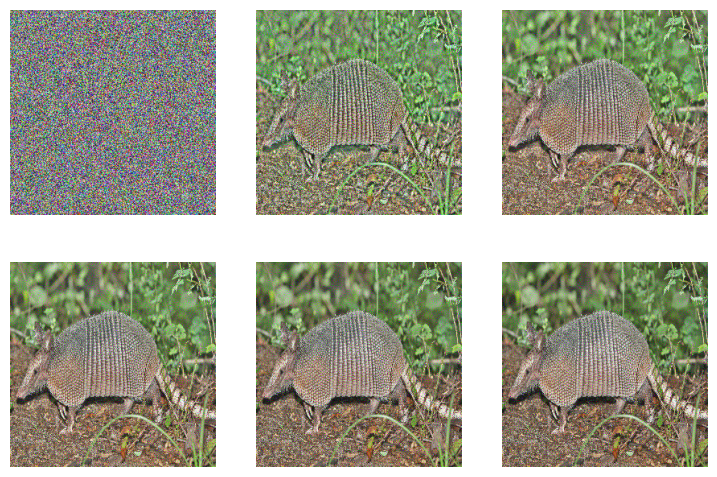

In [ ]:
set_seed(1103)
model = TensorModel(torch.rand_like(base_image))
cbs = [ImageOptCB(), ProgressCB(True), MetricsCB(), DeviceCB(), ImageLogCB(24)]
learn = Learner(model, get_dummy_dls(120), loss_func=ContentLossToTarget(base_image, (5,6)), lr=0.05, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit()

# Style loss with Gram matrix

In [ ]:
style_image = download_image(style_url).to(def_device)
style2_image = download_image(style2_url).to(def_device)

In [ ]:
calc_features??

Signature: calc_features(imgs, target_layers=(18, 25))
Docstring: <no docstring>
Source:   
def calc_features(imgs, target_layers=(18,25)):
    imgs = normalize(imgs)
    result = []
    last_layer = max(target_layers) + 1
    for i, layer in enumerate(vgg16[:last_layer]):
        imgs = layer(imgs)
        if i in target_layers:
            result.append(imgs)

    return result
File:      /tmp/ipykernel_694/2650550376.py
Type:      function

In [ ]:
def calc_grams(img, target_layers=(1,6,11,18,25)):
    features = calc_features(img, target_layers)
    result = []
    for feat in features:  # khw -> k^2
        result.append(
            torch.einsum("ahw,bhw->ab", feat, feat) * (1 / feat.shape[-1] / feat.shape[-2])
        )

    return result

In [ ]:
set_seed(1103, False)
grams = calc_grams(style_image)
for gram in grams:
    print(gram.shape)
del grams

torch.Size([64, 64])
torch.Size([128, 128])
torch.Size([256, 256])
torch.Size([512, 512])
torch.Size([512, 512])


In [ ]:
class StyleLossToTarget(nn.Module):
    def __init__(self, target_im, target_layers=(1,6,11,18,25)):
        super().__init__()
        with torch.no_grad():
            self.target = calc_grams(target_im, target_layers)
        self.target_layers = target_layers

    def __call__(self, x):
        grams = calc_grams(x, self.target_layers)
        loss = 0
        for i, g in enumerate(grams):
            loss += F.mse_loss(g, self.target[i])
        return loss

In [ ]:
StyleLossToTarget(style_image)(base_image)

tensor(1051.5330, device='cuda:0', grad_fn=<AddBackward0>)

# Style transfer

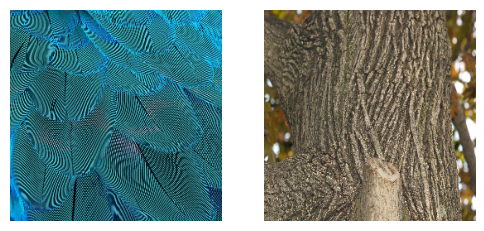

In [ ]:
show_images([style_image, style2_image])

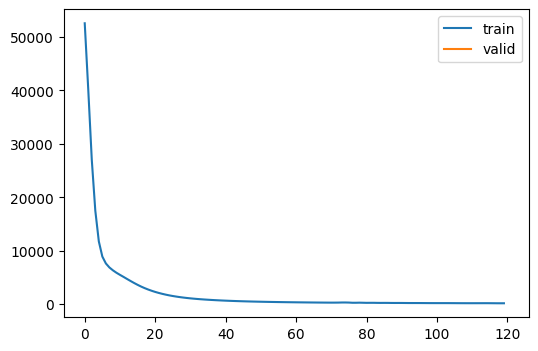

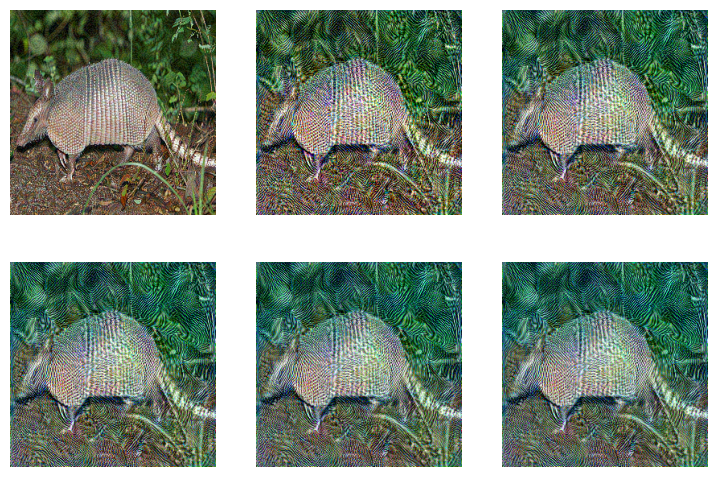

In [ ]:
set_seed(1103, False)

style_loss = StyleLossToTarget(style_image)
content_loss = ContentLossToTarget(base_image)
def transfer_loss(x):
    return style_loss(x) * 50 + content_loss(x)

model = TensorModel(base_image)
cbs = [ImageOptCB(), ProgressCB(True), MetricsCB(), DeviceCB(), ImageLogCB(24)]
learn = Learner(
    model, get_dummy_dls(120),
    loss_func=transfer_loss,
    lr=0.05, cbs=cbs, opt_func=torch.optim.Adam
)
learn.fit()

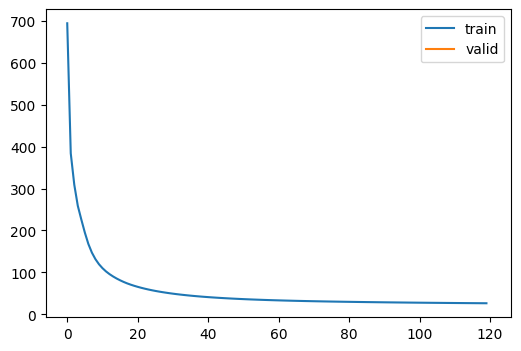

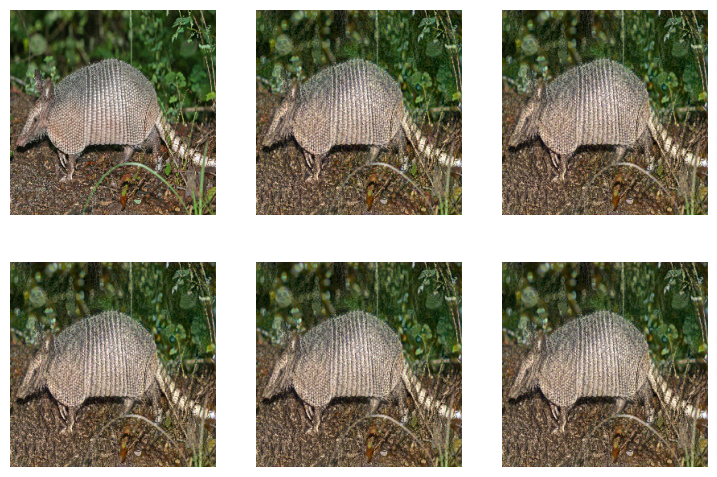

In [ ]:
set_seed(1103, False)

style_loss = StyleLossToTarget(style2_image)
content_loss = ContentLossToTarget(base_image)
def transfer_loss(x):
    return style_loss(x) * 50 + content_loss(x)

model = TensorModel(base_image)
cbs = [ImageOptCB(), ProgressCB(True), MetricsCB(), DeviceCB(), ImageLogCB(24)]
learn = Learner(
    model, get_dummy_dls(120),
    loss_func=transfer_loss,
    lr=0.01, cbs=cbs, opt_func=torch.optim.Adam
)
learn.fit()